# Period-$\phi_{31}$-[Fe/H] Relationship and Comparison

In [92]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore') 

# Reading the data from respective files and merging

df1=pd.read_csv("efourier_parameters_n4_1.txt",usecols=['gaiaid','period','p1','p3','ep1','ep3'])
df1['p31'] = df1['p3'] - 3*df1['p1']
df1['ep31'] = df1['ep3'] - 3*df1['ep1']
df2=pd.read_csv("merged_data.txt",usecols=['gaiaid','feh','feh_e'])
merged_df=df1.merge(df2,how='left',on='gaiaid')

# Extracting the required columns: period, fourier parameter and fe/h along with errors in them
gaiaid = merged_df['gaiaid']
p31=merged_df['p31']
period=merged_df['period']
feh=merged_df['feh']
feh_e=merged_df['feh_e']
ep31 = merged_df['ep31']

# 2*pi ambiguity removal 

for i in range(len(p31)):
    while(p31[i]<0):
        p31[i]+=2*np.pi
    while(p31[i]>2*np.pi):
        p31[i]-=2*np.pi
        
# 2*sigma clipping to remove outliers in the plane

lower_bound = np.mean(p31) - 2*np.std(p31)
upper_bound = np.mean(p31) + 2*np.std(p31)
mask = (p31 >= lower_bound) & (p31 <= upper_bound)
p31 = p31[mask]
period = period[mask]
feh = feh[mask]
feh_e = feh_e[mask]
ep31 = ep31[mask]
ep31 = abs(ep31)
gaiaid = gaiaid[mask]
print(len(ep31))

89


In [94]:
# Condition to remove points with potentially higher errorbar: Threshold = 0.2

condition = ep31 < 0.2 
condition2=ep31>0.2
Period2=period[condition2]
P312=p31[condition2]
Ep312=ep31[condition2]
period=period[condition]
p31=p31[condition]
ep31=ep31[condition]
feh=feh[condition]
feh_e=feh_e[condition]
gaiaid=gaiaid[condition]

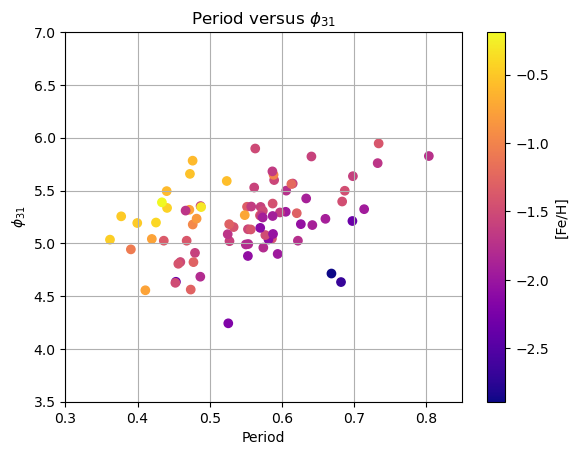

In [96]:
# Plotting period vs phi_31 in a plane with color-coded [Fe/H] values.

plt.title("Period versus $\phi_{31}$")
plt.xlabel("Period")
plt.ylabel("$\phi_{31}$")
plt.scatter(period,p31,c=feh,cmap='plasma')
plt.colorbar(label='[Fe/H]')
plt.grid()
plt.ylim(3.5,7)
plt.xlim(0.3,0.85)
plt.savefig('period_p31.png')

In [98]:
# Linear Regression starts from here

from scipy.odr import Data, Model, ODR

# Function to which the data is to be fitted along with offsets 

def f(B,X):
    return B[0]+B[1]*(X[0]-np.mean(X[0]))+B[2]*(X[1]-np.mean(X[1]))

# ODR Routine

linear = Model(f)
mydata = Data((period,p31),feh)
myodr = ODR(mydata, linear, beta0=[1., 1., 1.])
myoutput = myodr.run()
myoutput.pprint()
print(len(period))

Beta: [-1.46137806 -4.68198402  0.86267389]
Beta Std Error: [0.03654079 0.62049076 0.11223924]
Beta Covariance: [[ 1.64403395e-02 -6.11956003e-02  2.37797496e-03]
 [-6.11956003e-02  4.74051620e+00 -2.10933768e-01]
 [ 2.37797496e-03 -2.10933768e-01  1.55111658e-01]]
Residual Variance: 0.08121663788311148
Inverse Condition #: 0.06432787727066039
Reason(s) for Halting:
  Sum of squares convergence
83


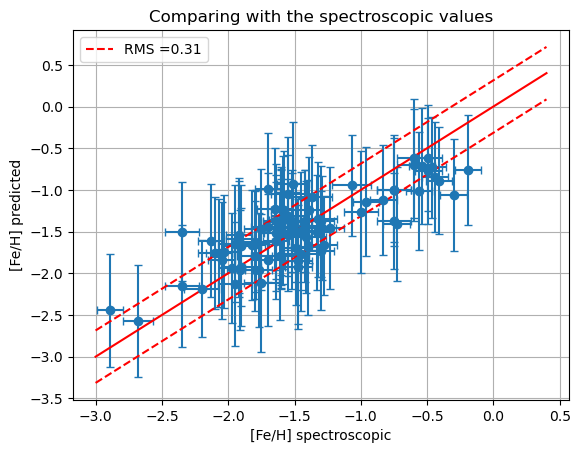

In [100]:
# Plotting the predicted [Fe/H] with respect to the spectroscopic [Fe/H]

sd_beta = myoutput.sd_beta
beta = myoutput.beta
predicted_Feh = beta[0]+beta[1]*(period-np.mean(period))+beta[2]*(p31-np.mean(p31))
rms_spec = np.sqrt(np.mean((feh-predicted_Feh)**2))

plt.title("Comparing with the spectroscopic values")
plt.ylabel("[Fe/H] predicted")
plt.xlabel("[Fe/H] spectroscopic")
err_feh = np.sqrt(sd_beta[0]**2 + (period* sd_beta[1])**2 + (p31* sd_beta[2])**2)
plt.errorbar(feh,predicted_Feh, yerr=err_feh,xerr = feh_e, fmt='o', capsize=3)
sample = np.arange(-3,0.5,0.1)
plt.plot(sample,sample,'r')
plt.plot(sample,sample+rms_spec,'--',color='r',label='RMS ='+str(round(rms_spec,2)))
plt.plot(sample,sample-rms_spec,'--',color='r')
plt.legend()
plt.grid()
plt.savefig("spectro.png")

In [102]:
# Predicting final [Fe/H] from relation obtained and then finding the rms values wrt other literature

Feh_JK96 = -5.038-5.394*(period) + 1.345*(p31) 
Feh_N13 = -5.241 - 5.394*(period) + 1.345*(p31+0.151)
Feh_IB20 = -1.68 - 5.08*(period-0.6) + 0.68*(p31+0.104-2-np.pi)
Feh_M21 = -1.22 - 7.60*(period-0.58) +1.42*(p31-5.25)

# C09 scaling for JK96 and IB20

Feh_JK96 *= 1.001
Feh_JK96 -= 0.112
Feh_IB20 *= 1.105
Feh_IB20 += 0.160

# RMS calculation

rms_jk96 = np.sqrt(np.mean((Feh_JK96-predicted_Feh)**2))
rms_n13 = np.sqrt(np.mean((Feh_N13-predicted_Feh)**2))
rms_ib20=np.sqrt(np.mean((Feh_IB20-predicted_Feh)**2))
rms_m21=np.sqrt(np.mean((Feh_M21-predicted_Feh)**2))

# This is the plots comparing with other literature:

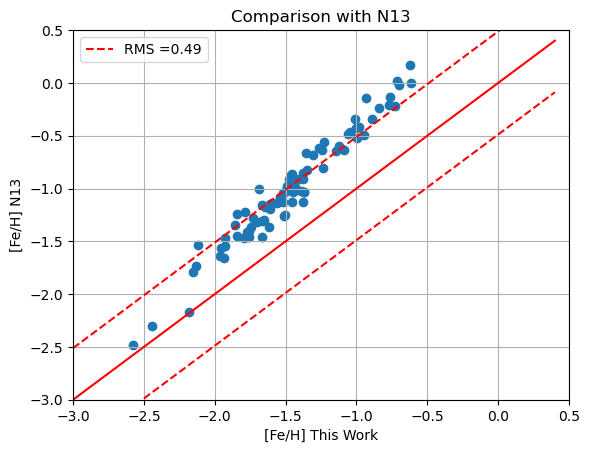

In [105]:
plt.scatter(predicted_Feh,Feh_N13)
plt.xlim(-3,0.5)
plt.ylim(-3,0.5)
plt.plot(sample,sample,color='r')
plt.plot(sample,sample+rms_n13,'--',color='r',label='RMS ='+str(round(rms_n13,2)))
plt.plot(sample,sample-rms_n13,'--',color='r')
plt.grid()
plt.legend()
plt.xlabel("[Fe/H] This Work")
plt.ylabel("[Fe/H] N13")
plt.title("Comparison with N13")
plt.savefig("n13.png")


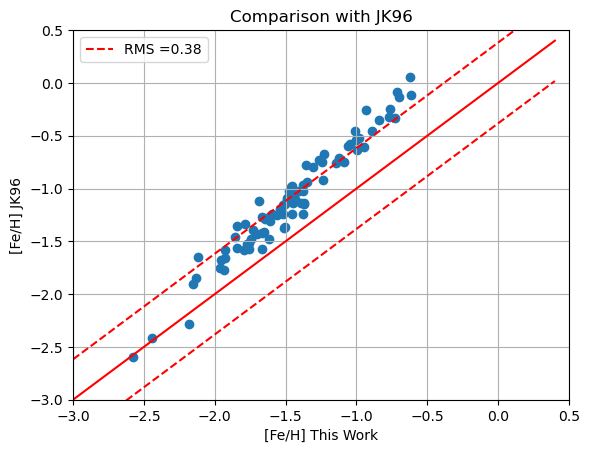

In [107]:
plt.scatter(predicted_Feh,Feh_JK96)
plt.xlim(-3,0.5)
plt.ylim(-3,0.5)
plt.plot(sample,sample,color='r')
plt.plot(sample,sample+rms_jk96,'--',color='r',label='RMS ='+str(round(rms_jk96,2)))
plt.plot(sample,sample-rms_jk96,'--',color='r')
plt.grid()
plt.legend()
plt.xlabel("[Fe/H] This Work")
plt.ylabel("[Fe/H] JK96")
plt.title("Comparison with JK96")
plt.savefig("jk96.png")

In [109]:
final_df=pd.DataFrame()
# Making the final table of [Fe/H] values:

In [111]:
final_df['gaiaid']=gaiaid
final_df['period']=period
final_df['p31']=p31
final_df['feh']=feh
final_df['feh_e']=feh_e
final_df['feh_p']=predicted_Feh
final_df['feh_pe']=err_feh

In [113]:
# Writing it to a text file

final_df.to_csv("final1.txt",index = False)

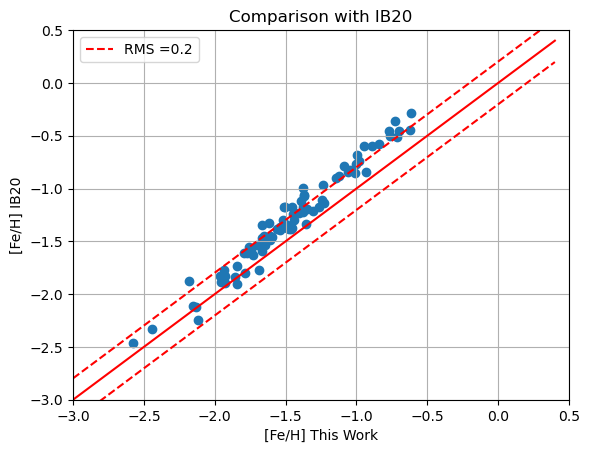

In [115]:
plt.scatter(predicted_Feh,Feh_IB20)
plt.xlim(-3,0.5)
plt.ylim(-3,0.5)
plt.plot(sample,sample+rms_ib20,'--',color='r',label='RMS ='+str(round(rms_ib20,2)))
plt.plot(sample,sample-rms_ib20,'--',color='r')
plt.plot(sample,sample,color='r')
plt.grid()
plt.legend()
plt.xlabel("[Fe/H] This Work")
plt.ylabel("[Fe/H] IB20")
plt.title("Comparison with IB20")
plt.savefig("ib20.png")

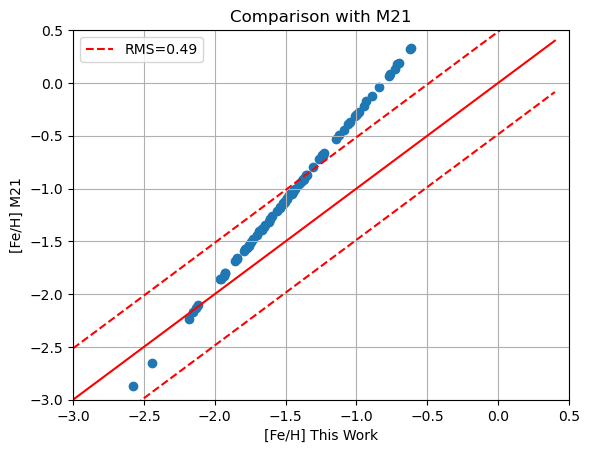

In [117]:
plt.scatter(predicted_Feh,Feh_M21)
plt.xlim(-3,0.5)
plt.ylim(-3,0.5)
plt.plot(sample,sample,'r')
plt.plot(sample,sample+rms_m21,'--',color='r',label='RMS='+str(round(rms_m21,2)))
plt.plot(sample,sample-rms_m21,'--',color='r')
plt.grid()
plt.legend()
plt.xlabel("[Fe/H] This Work")
plt.ylabel("[Fe/H] M21")
plt.title("Comparison with M21")
plt.savefig("m21.png")